In [ ]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
import yfinance as yf

start = '2021-01-01'
end = '2023-11-25'
period= '5y'
bnb = yf.download("BNB-USD", start, end)
bnb.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,37.374573,38.928177,37.046307,37.905010,37.905010,459165743
2021-01-02,37.917107,38.836254,36.925602,38.241592,38.241592,521965394
2021-01-03,38.253727,41.606323,37.818104,41.148979,41.148979,758008613
2021-01-04,41.198280,43.132122,38.143982,40.926353,40.926353,807877171
2021-01-05,40.937279,41.734600,38.978954,41.734600,41.734600,644270927


##Explore the data

In [ ]:
bnb.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1058 entries, 2021-01-01 to 2023-11-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1058 non-null   float64
 1   High       1058 non-null   float64
 2   Low        1058 non-null   float64
 3   Close      1058 non-null   float64
 4   Adj Close  1058 non-null   float64
 5   Volume     1058 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 57.9 KB


In [ ]:
len(bnb)

1058

In [ ]:
bnb.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1.058000e+03
mean,325.344776,334.721835,315.226615,325.476360,325.476360,1.656161e+09
std,119.429837,123.767773,114.228153,118.999307,118.999307,1.612872e+09
min,37.374573,38.836254,35.170883,37.905010,37.905010,2.038465e+08
25%,246.718380,253.701893,242.287746,246.728333,246.728333,5.765946e+08
50%,305.104919,311.872299,297.125275,305.104477,305.104477,1.225325e+09
75%,390.177711,402.654045,374.882339,390.233559,390.233559,2.101789e+09
max,676.315918,690.931946,634.549500,675.684082,675.684082,1.798295e+10


##Visualize the data

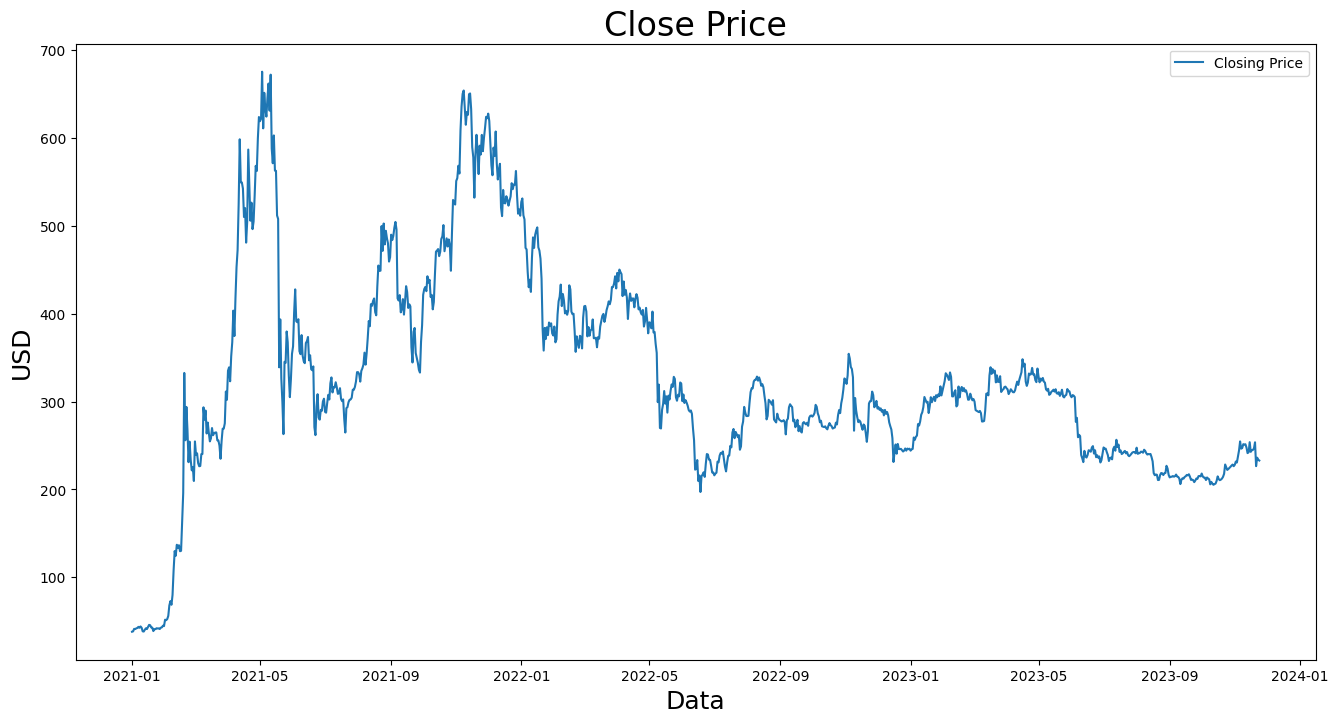

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Close Price', fontsize=24)
plt.plot(bnb.index, bnb['Close'], label = 'Closing Price')
plt.xlabel('Data', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.legend()
plt.show()

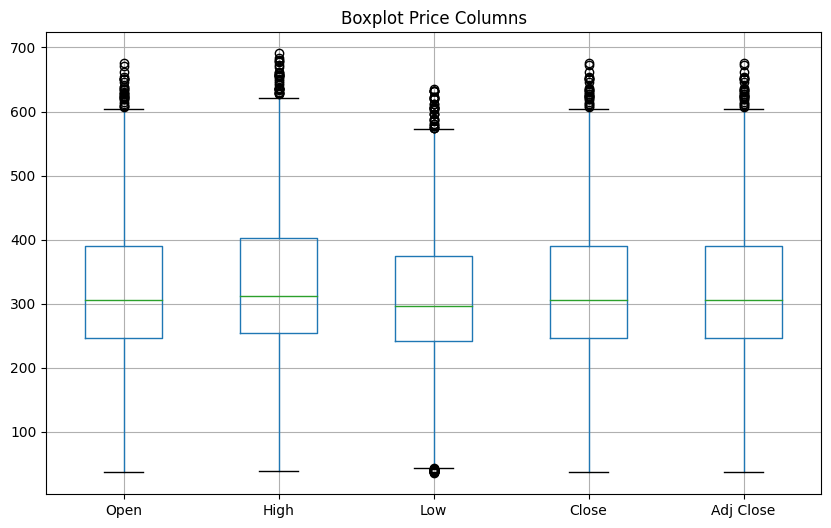

In [ ]:
plt.figure(figsize=(10, 6))
bnb.boxplot(column=['Open', 'High', 'Low', 'Close', 'Adj Close'])
plt.title(f'Boxplot Price Columns')
plt.show()

##Check missing values

In [ ]:
print("Missing values: ")
print(bnb.isnull().sum())

Missing values: 
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


<Axes: ylabel='Date'>

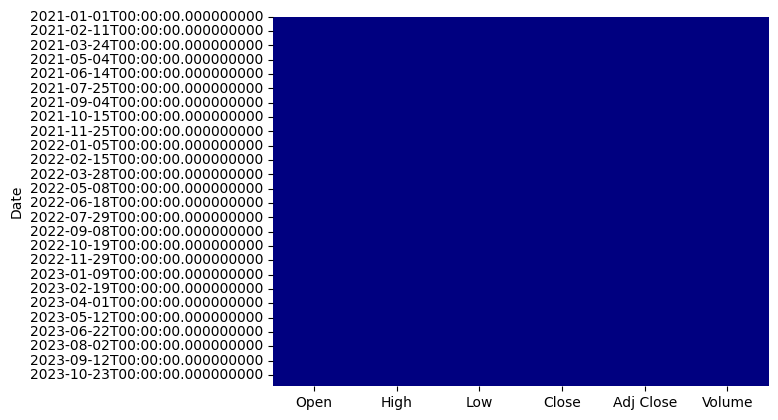

In [ ]:
import seaborn as sns

sns.heatmap(bnb.isnull(), cmap='jet', cbar=False)

##Preprocess data

In [ ]:
#Creat a new dataframe with only Close Price
bnb_data = bnb.filter(['Close'])
#Convert the dataframe to numpy array
bnb_dataset = bnb_data.values.reshape(-1, 1)
print(bnb_dataset)
# Get the number of rows to train the model on. we need this number to create our train and test sets
print("Data's length: ", len(bnb_dataset))

[[ 37.90501022]
 [ 38.24159241]
 [ 41.14897919]
 ...
 [236.13659668]
 [233.76580811]
 [232.9009552 ]]
Data's length:  1058


In [ ]:
# math.ceil will round up the number
bnb_training_data_len = math.ceil(len(bnb_dataset) * .8) # We are using %80 of the data for training
bnb_training_data_len

847

##Normalize the data

In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
bnb_dataset = scaler.fit_transform(bnb_dataset)
bnb_dataset

array([[0.        ],
       [0.00052774],
       [0.00508635],
       ...,
       [0.31081545],
       [0.30709819],
       [0.30574215]])

In [ ]:
# Creat the training dataset
train_data = bnb_dataset[0:bnb_training_data_len, :]

n_lookback = 120 # Input sequences
n_forecast = 60 # Prediction

# Split the data into X_train and y_train data sets
bnb_X = []
bnb_y = []

for i in range(n_lookback, len(train_data) - n_forecast + 1):
  bnb_X.append(train_data[i - n_lookback: i])
  bnb_y.append(train_data[i: i + n_forecast])

print(len(bnb_X))
print(len(bnb_y))

668
668


In [ ]:
# Convert the X_train and y_train to numpy array
bnb_X, bnb_y = np.array(bnb_X), np.array(bnb_y)

In [ ]:
print(bnb_X.shape)
print(bnb_y.shape)

(668, 120, 1)
(668, 60, 1)


##Make model

In [ ]:
# Create the testing dataset
# Create a new array containing scaled values from index 2083
bnb_model = Sequential()
bnb_model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
bnb_model.add(LSTM(units=50))
bnb_model.add(Dense(n_forecast))

# adam = Adam(learning_rate = 5e-3)
bnb_model.compile(loss='mean_squared_error', optimizer='adam')


##Training


In [ ]:
print(bnb_X.shape)
print(bnb_y.shape)

(668, 120, 1)
(668, 60, 1)


In [ ]:
bnb_training_size = int(bnb_X.shape[0] * 0.8)
bnb_training_size

534

In [ ]:
bnb_X_train, bnb_y_train = bnb_X[:bnb_training_size], bnb_y[:bnb_training_size]
bnb_X_test, bnb_y_test = bnb_X[bnb_training_size:], bnb_y[bnb_training_size: ]

In [ ]:
history = bnb_model.fit(bnb_X_train, bnb_y_train,
                            epochs = 100,
                            batch_size = 32,
                            validation_data = (bnb_X_test, bnb_y_test))

Epoch 1/100
17/17 [==============================] - 9s 229ms/step - loss: 0.2243 - val_loss: 0.0649
Epoch 2/100
17/17 [==============================] - 2s 136ms/step - loss: 0.0538 - val_loss: 0.0209
Epoch 3/100
17/17 [==============================] - 4s 208ms/step - loss: 0.0228 - val_loss: 0.0124
Epoch 4/100
17/17 [==============================] - 2s 129ms/step - loss: 0.0194 - val_loss: 0.0067
Epoch 5/100
17/17 [==============================] - 2s 121ms/step - loss: 0.0186 - val_loss: 0.0031
Epoch 6/100
17/17 [==============================] - 2s 120ms/step - loss: 0.0180 - val_loss: 0.0029
Epoch 7/100
17/17 [==============================] - 2s 119ms/step - loss: 0.0175 - val_loss: 0.0039
Epoch 8/100
17/17 [==============================] - 2s 130ms/step - loss: 0.0189 - val_loss: 0.0040
Epoch 9/100
17/17 [==============================] - 4s 211ms/step - loss: 0.0176 - val_loss: 0.0083
Epoch 10/100
17/17 [==============================] - 2s 143ms/step - loss: 0.0172 - val_lo

Text(0.5, 0, 'epochs')

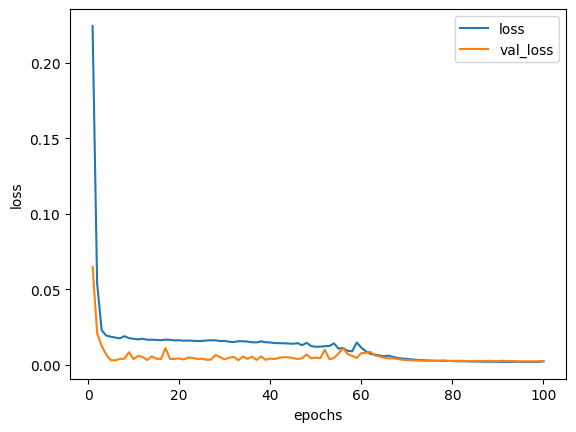

In [ ]:
#Plot the training
historyForPlot = pd.DataFrame(history.history)
historyForPlot.index += 1 # we plus 1 to the number of indexing so our epochs Plot picture will be counting from 1 not 0.
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")

##Generate forecasts

In [ ]:
predict = bnb_model.predict(bnb_X_test[-1 : : ])
predict = scaler.inverse_transform(predict)
predict

1/1 [==============================] - 1s 875ms/step


array([[299.62943, 302.44498, 298.19666, 291.79523, 302.2867 , 288.9774 ,
        293.80148, 297.45325, 299.25775, 288.3418 , 290.0842 , 280.08255,
        275.13217, 289.36914, 287.6839 , 293.94165, 285.35043, 290.01163,
        280.00223, 288.4386 , 286.12   , 296.39215, 292.8733 , 293.94794,
        289.57892, 298.66763, 295.9085 , 301.71872, 299.12054, 300.263  ,
        307.06204, 305.37888, 308.0183 , 304.9888 , 315.88074, 311.02847,
        313.22098, 317.78177, 319.9332 , 321.74197, 322.36514, 322.03638,
        310.12302, 331.4082 , 321.29703, 331.716  , 332.9065 , 335.0469 ,
        329.08185, 329.5624 , 325.16605, 328.52222, 330.22565, 336.16162,
        342.9787 , 333.98428, 338.83963, 343.0254 , 341.33252, 338.795  ]],
      dtype=float32)

In [ ]:
check_pred = bnb_y_test[-1 : : ]
# check_pred = scaler.inverse_transform(check_pred)
check_pred = check_pred.reshape(-1 , 1)
check_pred = scaler.inverse_transform(check_pred)
check_pred

array([[304.85580444],
       [301.474823  ],
       [302.9074707 ],
       [299.94616699],
       [290.28283691],
       [289.50387573],
       [288.69970703],
       [288.05496216],
       [289.34368896],
       [286.86700439],
       [277.29611206],
       [277.41958618],
       [277.96142578],
       [289.67578125],
       [308.91220093],
       [309.37078857],
       [307.12493896],
       [329.86087036],
       [339.08114624],
       [331.52429199],
       [336.97824097],
       [332.92300415],
       [335.30923462],
       [321.88772583],
       [329.83700562],
       [322.35934448],
       [322.67306519],
       [328.88800049],
       [310.9491272 ],
       [313.26062012],
       [313.84176636],
       [316.56756592],
       [317.04000854],
       [315.21731567],
       [313.92861938],
       [308.56237793],
       [310.99484253],
       [314.06317139],
       [312.45465088],
       [310.69949341],
       [310.63473511],
       [312.87225342],
       [318.37905884],
       [322

In [ ]:
predict.shape

(1, 60)

In [ ]:
check_pred.shape
check_pred = check_pred.flatten()
check_pred.shape

(60,)

In [ ]:
predict = predict.flatten()
predict.shape

(60,)

##Ploting

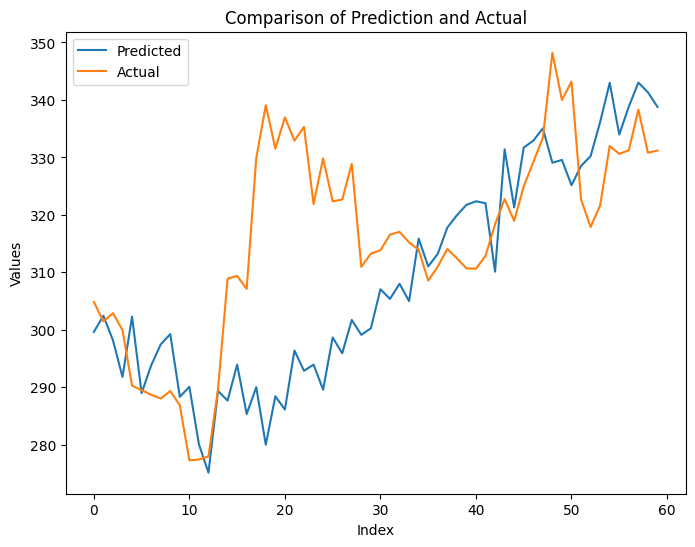

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

predict = np.array(predict)
check_pred = np.array(check_pred)

plt.figure(figsize=(8, 6))
plt.plot(predict, label='Predicted')
plt.plot(check_pred, label='Actual')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Comparison of Prediction and Actual')
plt.legend()
plt.show()

In [ ]:
bnb_lookback = bnb_dataset[-n_lookback:]

bnb_lookback = bnb_lookback.reshape(1, n_lookback, 1)


In [ ]:
bnb_forecast = bnb_model.predict(bnb_lookback)
bnb_forecast = scaler.inverse_transform(bnb_forecast)

1/1 [==============================] - 0s 35ms/step


In [ ]:
bnb_forecast

array([[240.08662, 238.69693, 236.50417, 239.8516 , 229.64127, 233.12392,
        234.41017, 235.93614, 241.42558, 237.96858, 235.93011, 228.71606,
        218.30359, 236.89218, 234.5356 , 236.63474, 232.32861, 236.63635,
        229.00868, 238.34532, 234.23245, 244.7664 , 232.3045 , 230.13853,
        230.31883, 239.77493, 228.30736, 235.22853, 230.23386, 232.2053 ,
        235.576  , 234.15662, 235.34723, 229.45982, 237.12527, 234.63853,
        228.001  , 228.9367 , 226.95013, 227.9263 , 230.98349, 226.14075,
        218.55931, 224.27531, 220.92628, 221.8687 , 218.02823, 222.4459 ,
        217.61823, 218.80713, 217.58792, 217.6105 , 217.04839, 219.91557,
        224.728  , 215.20862, 217.19765, 218.2891 , 221.69212, 211.7042 ]],
      dtype=float32)

In [ ]:
import plotly.graph_objects as go

##Visualize the Forcasts

In [ ]:
bnb_past = bnb[['Close']][-180:].reset_index()
bnb_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
bnb_past['Date'] = pd.to_datetime(bnb_past['Date'])
bnb_past['Forecast'] = np.nan
bnb_past['Forecast'].iloc[-1] = bnb_past['Actual'].iloc[-1]


bnb_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
bnb_future['Date'] = pd.date_range(start=bnb_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
bnb_future['Forecast'] = bnb_forecast.flatten()
bnb_future['Actual'] = np.nan


results = pd.concat([bnb_past, bnb_future]).set_index('Date')


fig = px.line(results, x=results.index, y=['Actual', 'Forecast'], title='Binance Coin Forecasting in 2 months')
fig.add_shape(
    go.layout.Shape(
        type="line",
        x0=results.index[-n_forecast], y0=results['Actual'].min(),
        x1=results.index[-n_forecast], y1=results['Actual'].max(),
        line=dict(color="red", width=1, dash="dash")
    )
)
fig.show()

<ipython-input-312-856756bd9cf8>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
results.shape
print("Price of Binance Coin on", results.index[-n_forecast], "should be ",results.Forecast[-n_forecast])

Price of Binance Coin on 2023-11-25 00:00:00 should be  240.0866241455078


In [ ]:
bnb_model.save('bnb.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



#Try with Emeren Group

In [ ]:
sol = yf.download(tickers=['SOL'], period='15y')
sol.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-11-25,14.90,15.600000,12.75,14.75,14.75,413100
2008-11-26,13.65,17.700001,13.60,15.95,15.95,753680
2008-11-28,16.10,18.250000,16.10,17.35,17.35,284100
2008-12-01,16.10,16.100000,13.55,13.60,13.60,349420
2008-12-02,14.50,16.000000,13.70,15.65,15.65,297100


##Explore data


In [ ]:
sol.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3775 entries, 2008-11-25 to 2023-11-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3775 non-null   float64
 1   High       3775 non-null   float64
 2   Low        3775 non-null   float64
 3   Close      3775 non-null   float64
 4   Adj Close  3775 non-null   float64
 5   Volume     3775 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 206.4 KB


In [ ]:
len(sol)

3775

In [ ]:
sol.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000,3.775000e+03
mean,11.394922,11.766005,11.000188,11.365764,11.365764,5.217399e+05
std,12.338297,12.674638,11.939748,12.293157,12.293157,1.039419e+06
min,0.850000,0.920000,0.850000,0.860000,0.860000,5.000000e+02
25%,3.065000,3.165000,3.000000,3.060000,3.060000,6.330000e+04
50%,6.850000,7.050000,6.600000,6.800000,6.800000,2.320000e+05
75%,14.625000,15.050000,13.850000,14.500000,14.500000,5.568100e+05
max,73.199997,76.699997,71.900002,72.750000,72.750000,2.083310e+07


##Visualize the data

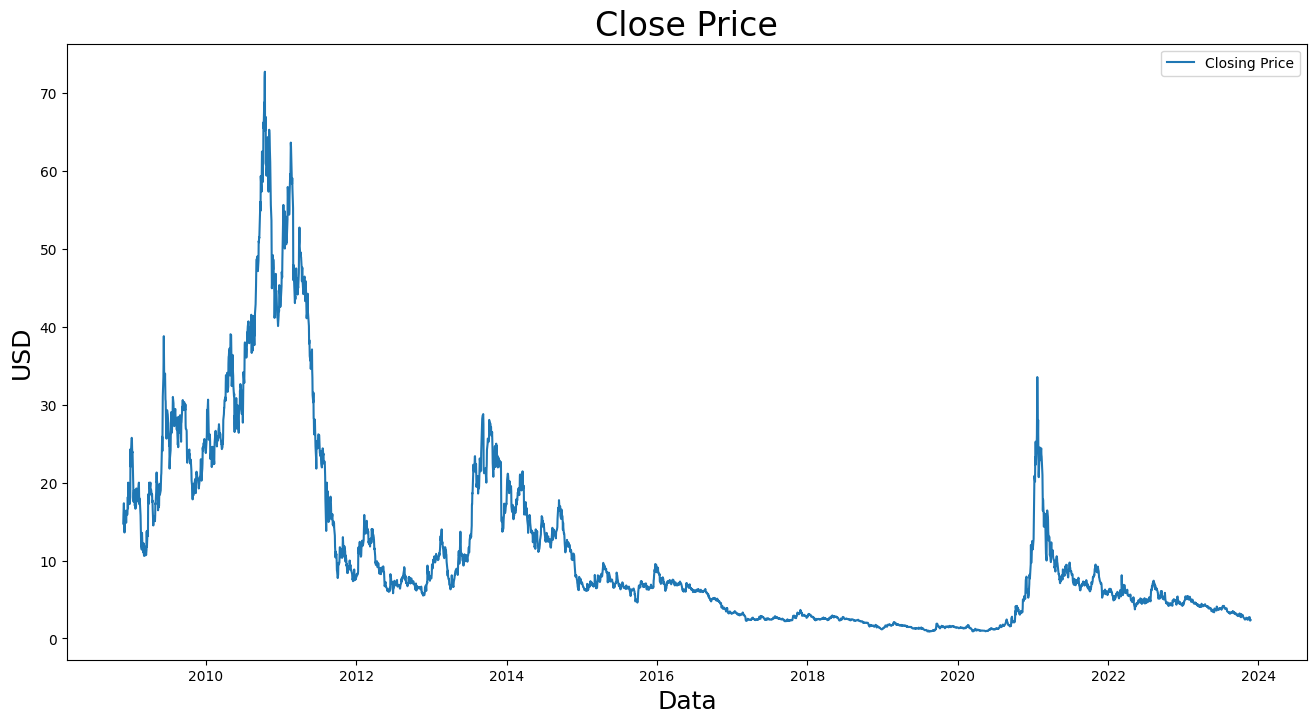

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Close Price', fontsize=24)
plt.plot(sol.index, sol['Close'], label = 'Closing Price')
plt.xlabel('Data', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.legend()
plt.show()

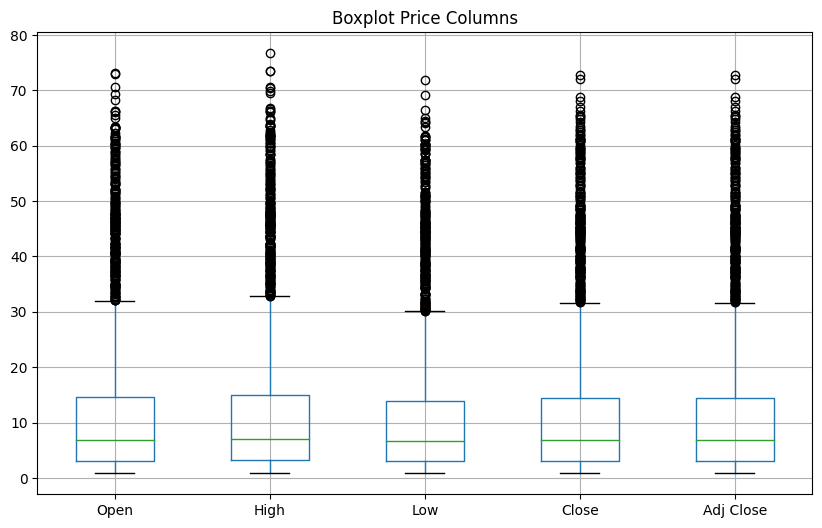

In [ ]:
plt.figure(figsize=(10, 6))
sol.boxplot(column=['Open', 'High', 'Low', 'Close', 'Adj Close'])
plt.title(f'Boxplot Price Columns')
plt.show()

##Check missing values

In [ ]:
print("Missing values: ")
print(sol.isnull().sum())

Missing values: 
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


<Axes: ylabel='Date'>

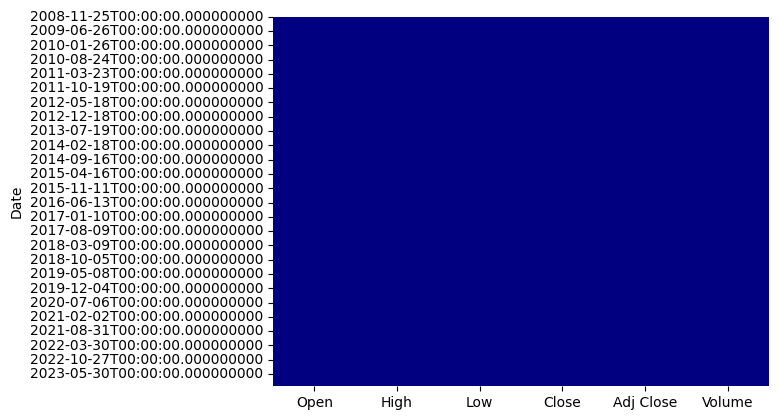

In [ ]:
sns.heatmap(sol.isnull(), cmap='jet', cbar=False)

##Preprocess data


In [ ]:
#Creat a new dataframe with only Close Price
sol_data = sol.filter(['Close'])
#Convert the dataframe to numpy array
sol_dataset = sol_data.values.reshape(-1, 1)
print(sol_dataset)
# Get the number of rows to train the model on. we need this number to create our train and test sets
print("Data's length: ", len(sol_dataset))

[[14.75      ]
 [15.94999981]
 [17.35000038]
 ...
 [ 2.61999989]
 [ 2.27999997]
 [ 2.3599999 ]]
Data's length:  3775


In [ ]:
# math.ceil will round up the number
sol_training_data_len = math.ceil(len(sol_dataset) * .8) # We are using %80 of the data for training
sol_training_data_len

3020

##Normalize the data

In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
sol_dataset = scaler.fit_transform(sol_dataset)
sol_dataset

array([[0.19321185],
       [0.20990402],
       [0.22937822],
       ...,
       [0.02448185],
       [0.0197524 ],
       [0.02086521]])

In [ ]:
# Create the training dataset
train_data = sol_dataset[0:sol_training_data_len, :]

n_lookback = 120 # Input sequences
n_forecast = 60 # Prediction

# Split the data into X_train and y_train data sets
sol_X = []
sol_y = []

for i in range(n_lookback, len(train_data) - n_forecast + 1):
  sol_X.append(train_data[i - n_lookback: i])
  sol_y.append(train_data[i: i + n_forecast])

print(len(sol_X))
print(len(sol_y))

2841
2841


In [ ]:
# Convert the X_train and y_train to numpy array
sol_X, sol_y = np.array(sol_X), np.array(sol_y)

In [ ]:
print(sol_X.shape)
print(sol_y.shape)

(2841, 120, 1)
(2841, 60, 1)


##Make model

In [ ]:
# Create the testing dataset
# Create a new array containing scaled values from index 2083
sol_model = Sequential()
sol_model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
sol_model.add(LSTM(units=50))
sol_model.add(Dense(n_forecast))

# adam = Adam(learning_rate = 5e-3)
sol_model.compile(loss='mean_squared_error', optimizer='adam')

##Training

In [ ]:
print(sol_X.shape)
print(sol_y.shape)

(2841, 120, 1)
(2841, 60, 1)


In [ ]:
sol_training_size = int(bnb_X.shape[0] * 0.8)
sol_training_size

534

In [ ]:
sol_X_train, sol_y_train = sol_X[:sol_training_size], sol_y[:sol_training_size]
sol_X_test, sol_y_test = sol_X[sol_training_size:], sol_y[sol_training_size: ]

In [ ]:
history = sol_model.fit(sol_X_train, sol_y_train,
                            epochs = 100,
                            batch_size = 32,
                            validation_data = (sol_X_test, sol_y_test))

Epoch 1/100
17/17 [==============================] - 10s 312ms/step - loss: 0.1910 - val_loss: 0.0301
Epoch 2/100
17/17 [==============================] - 7s 455ms/step - loss: 0.0454 - val_loss: 0.0184
Epoch 3/100
17/17 [==============================] - 4s 256ms/step - loss: 0.0201 - val_loss: 0.0092
Epoch 4/100
17/17 [==============================] - 4s 243ms/step - loss: 0.0190 - val_loss: 0.0055
Epoch 5/100
17/17 [==============================] - 6s 365ms/step - loss: 0.0176 - val_loss: 0.0074
Epoch 6/100
17/17 [==============================] - 4s 243ms/step - loss: 0.0178 - val_loss: 0.0046
Epoch 7/100
17/17 [==============================] - 4s 250ms/step - loss: 0.0181 - val_loss: 0.0094
Epoch 8/100
17/17 [==============================] - 6s 360ms/step - loss: 0.0173 - val_loss: 0.0079
Epoch 9/100
17/17 [==============================] - 4s 251ms/step - loss: 0.0172 - val_loss: 0.0051
Epoch 10/100
17/17 [==============================] - 4s 242ms/step - loss: 0.0170 - val_l

Text(0.5, 0, 'epochs')

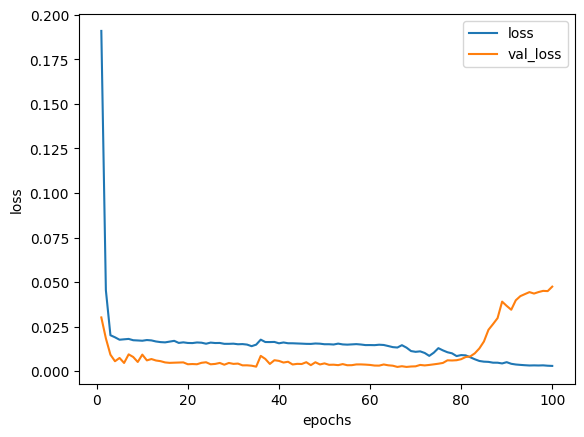

In [ ]:
#Plot the training
historyForPlot = pd.DataFrame(history.history)
historyForPlot.index += 1 # we plus 1 to the number of indexing so our epochs Plot picture will be counting from 1 not 0.
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")

##Generate Forecasts

In [ ]:
predict = sol_model.predict(sol_X_test[-1 : : ])
predict = scaler.inverse_transform(predict)
predict

1/1 [==============================] - 1s 896ms/step


array([[14.846115 , 12.805574 , 14.042929 , 14.6974325, 16.850813 ,
        16.817415 , 18.513666 , 14.952166 , 17.306917 , 18.537302 ,
        19.816938 , 20.794647 , 19.61811  , 20.620121 , 19.536316 ,
        16.70342  , 17.934399 , 16.24751  , 16.218607 , 20.886818 ,
        19.587318 , 21.524397 , 22.032276 , 19.74019  , 22.95591  ,
        20.3436   , 22.210707 , 19.555859 , 20.66917  , 25.96395  ,
        21.836527 , 22.461155 , 24.290503 , 24.890076 , 23.364334 ,
        23.244686 , 23.281223 , 23.75912  , 23.727488 , 23.1781   ,
        22.865816 , 23.917353 , 21.083176 , 20.503023 , 21.682018 ,
        24.199858 , 21.798594 , 22.210888 , 22.471321 , 22.992407 ,
        18.323433 , 17.954002 , 21.825026 , 20.759996 , 19.029041 ,
        21.0507   , 19.456533 , 16.630608 , 20.217155 , 18.591648 ]],
      dtype=float32)

In [ ]:
check_pred = sol_y_test[-1 : : ]
check_pred = check_pred.reshape(-1 , 1)
check_pred = scaler.inverse_transform(check_pred)
check_pred

array([[2.00999999],
       [1.86000001],
       [1.83000004],
       [1.72000003],
       [1.70000005],
       [1.72000003],
       [1.72000003],
       [1.58000004],
       [1.53999996],
       [1.59000003],
       [1.62      ],
       [1.58000004],
       [2.05999994],
       [2.57999992],
       [2.78999996],
       [2.38000011],
       [2.0999999 ],
       [2.05999994],
       [2.1400001 ],
       [2.21000004],
       [2.0999999 ],
       [2.06999993],
       [2.16000009],
       [2.06999993],
       [2.13000011],
       [2.6400001 ],
       [3.5       ],
       [3.01999998],
       [4.1500001 ],
       [3.3900001 ],
       [3.80999994],
       [3.66000009],
       [4.17999983],
       [3.81999993],
       [3.8900001 ],
       [3.94000006],
       [3.6400001 ],
       [3.73000002],
       [3.56999993],
       [3.22000003],
       [3.13000011],
       [3.08999991],
       [3.16000009],
       [3.06999993],
       [3.46000004],
       [3.3499999 ],
       [3.27999997],
       [3.5  

In [ ]:
predict.shape

(1, 60)

In [ ]:
check_pred.shape
check_pred = check_pred.flatten()
check_pred.shape

(60,)

In [ ]:
predict = predict.flatten()
predict.shape

(60,)

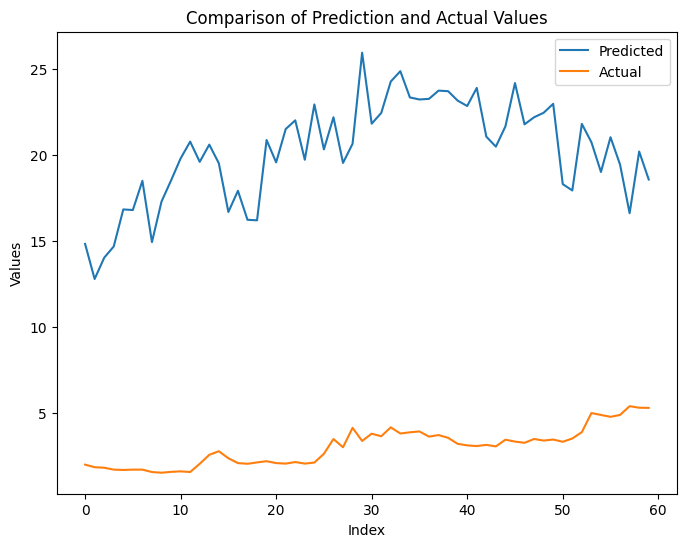

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

predict = np.array(predict)  # Convert predict to numpy array if it's not already
check_pred = np.array(check_pred)  # Convert check_pred to numpy array if it's not already

plt.figure(figsize=(8, 6))
plt.plot(predict, label='Predicted')
plt.plot(check_pred, label='Actual')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Comparison of Prediction and Actual Values')
plt.legend()
plt.show()

In [ ]:
sol_lookback = sol_dataset[-n_lookback:]
sol_lookback = sol_lookback.reshape(1, n_lookback, 1)

In [ ]:
sol_forecast = sol_model.predict(sol_lookback)
sol_forecast = scaler.inverse_transform(sol_forecast)

1/1 [==============================] - 0s 33ms/step


In [ ]:
sol_forecast

array([[15.002086, 12.952719, 14.190477, 14.789086, 16.974154, 17.010696,
        18.598455, 15.133918, 17.372429, 18.639963, 19.817951, 20.817474,
        19.755726, 20.653421, 19.612455, 16.816292, 18.046354, 16.427767,
        16.38512 , 20.924765, 19.69618 , 21.51828 , 22.026415, 19.846916,
        23.036465, 20.43736 , 22.22751 , 19.648228, 20.699106, 25.912663,
        21.9023  , 22.452477, 24.292894, 24.887457, 23.400692, 23.241318,
        23.341732, 23.752913, 23.724508, 23.204384, 22.962889, 23.96491 ,
        21.191334, 20.620455, 21.728243, 24.240461, 21.8276  , 22.327091,
        22.478724, 23.038008, 18.473421, 18.11603 , 21.833527, 20.901827,
        19.099264, 21.066519, 19.546474, 16.81202 , 20.292513, 18.666483]],
      dtype=float32)

##Visual the Forcasts

In [ ]:
sol_past = sol[['Close']][-180:].reset_index()
sol_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
sol_past['Date'] = pd.to_datetime(sol_past['Date'])
sol_past['Forecast'] = np.nan
sol_past['Forecast'].iloc[-1] = sol_past['Actual'].iloc[-1]


sol_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
sol_future['Date'] = pd.date_range(start=sol_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
sol_future['Forecast'] = sol_forecast.flatten()
sol_future['Actual'] = np.nan


results = pd.concat([sol_past, sol_future]).set_index('Date')


fig = px.line(results, x=results.index, y=['Actual', 'Forecast'], title='Emeren Group  Forecasting in 2 months')
fig.add_shape(
    go.layout.Shape(
        type="line",
        x0=results.index[-n_forecast], y0=results['Actual'].min(),
        x1=results.index[-n_forecast], y1=results['Actual'].max(),
        line=dict(color="red", width=1, dash="dash")
    )
)
fig.show()

<ipython-input-407-e217e35dea9d>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
results.shape
print("Price of Emeren Group on", results.index[-n_forecast], "should be ",results.Forecast[-n_forecast])

Price of Emeren Group on 2023-11-25 00:00:00 should be  15.00208568572998


In [ ]:
sol_model.save('sol.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

